In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [ ]:
# Importar o drive do google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Leitura da base
df = pd.read_csv('/content/drive/MyDrive/ESTUDOS_COLAB/train.csv', sep=',')

In [ ]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [ ]:
#crosstable -> tabela dinamica , bom para fazer umas validações
x_test = pd.crosstab(df['OutcomeType'], df['AnimalType'], normalize='index')
x_test

AnimalType,Cat,Dog
OutcomeType,,
Adoption,0.396694,0.603306
Died,0.746193,0.253807
Euthanasia,0.456592,0.543408
Return_to_owner,0.104471,0.895529
Transfer,0.584271,0.415729


In [ ]:
# Qual status mais proveniente?
df['OutcomeType'].value_counts(normalize=True)

Adoption           0.402896
Transfer           0.352501
Return_to_owner    0.179056
Euthanasia         0.058177
Died               0.007370
Name: OutcomeType, dtype: float64

In [ ]:
# Retirar colunas que não interessam
df.drop(labels=['AnimalID','Name'], axis=1, inplace=True)

In [ ]:
df.head()

,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


# Explore Data Analysis

In [ ]:
# Agrupar a base e comecar a EDA
df_g = df.groupby(by=['OutcomeType','AnimalType']).count()
df_g = df_g.reset_index()
df_g = df_g[['OutcomeType','AnimalType','DateTime']].sort_values(by=['DateTime'], ascending=False)
df_g

,OutcomeType,AnimalType,DateTime
1,Adoption,Dog,6497
8,Transfer,Cat,5505
7,Return_to_owner,Dog,4286
0,Adoption,Cat,4272
9,Transfer,Dog,3917
5,Euthanasia,Dog,845
4,Euthanasia,Cat,710
6,Return_to_owner,Cat,500
2,Died,Cat,147
3,Died,Dog,50


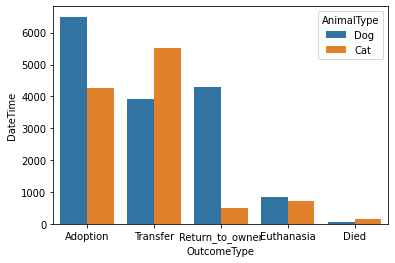

In [ ]:
# Verificar qual os status com a especie -> Percebemos aqui que os cachorros são mais adotados que os gatinhos, os gatinhos são mais transferidos
sns.barplot(x='OutcomeType', y="DateTime", hue='AnimalType' ,data=df_g)

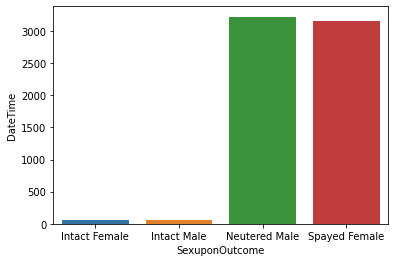

In [ ]:
# Aqui eu quero testar se os cachorros adotados são castrados
x = df[df['OutcomeType']=='Adoption'] # Filtrar na tabela tudo que foi adotado
x = x[x['AnimalType']=='Dog'] # Filtrar na tabela de adotados tudo que é cachorro
df_gg = x.groupby(by=['OutcomeType','SexuponOutcome']).count() # Agrupamento
df_gg = df_gg.reset_index() # Retirar indices
sns.barplot(x='SexuponOutcome', y="DateTime" ,data=df_gg) # Plotar o gráfico
# Aqui é possivel concluir que praticamente todos os doguinhos adotados são castrados

In [ ]:
# Aqui eu quero saber o tempo que os dog's adotados ficaram no abrigo
y = df[(df['OutcomeType']=='Adoption') & (df['AnimalType']=='Dog')].groupby(by=['AgeuponOutcome']).count()
y = y.reset_index()
y = y[['AgeuponOutcome','DateTime']].sort_values(by=['DateTime'], ascending = False)
y.head(5)
# Os dog's que possuem em média 2 anos no abrigo

,AgeuponOutcome,DateTime
1,1 year,1354
12,2 years,1161
11,2 months,837
14,3 years,484
16,4 years,281


In [ ]:
# Preparar para calcular a média de dias abrigado, fazendo uma transformação dos dados
df_t = df['AgeuponOutcome'].str.split(expand = True)
df_t  = df_t.rename(columns={0: "Number", 1: "Date_Status"})
df_t

,Number,Date_Status
0,1,year
1,1,year
2,2,years
3,3,weeks
4,2,years
...,...,...
26724,1,month
26725,3,months
26726,4,years
26727,4,weeks


In [ ]:
# Funçãozinha para transformar para dias
def coloca(cols):
    Locais = cols[1]
    if Locais == 'day':
        return 1
    elif Locais =='days':
        return 1
    elif Locais == 'month':
        return 30
    elif Locais == 'months':
        return 30
    elif Locais == 'week':
        return 7
    elif Locais == 'weeks':
        return 7
    elif Locais == 'year':
        return 365
    else:
        return 365

In [ ]:
# Calcular o total de dias com base na funçãozinha
df_t['Conversion'] = df_t.apply(coloca, axis=1)
df_t['Number'] = pd.to_numeric(df_t['Number'], downcast='integer')
df_t['Conversion'] = pd.to_numeric(df_t['Conversion'])
df_t['TotalDias'] = df_t['Number']*df_t['Conversion']
df_t

,Number,Date_Status,Conversion,TotalDias
0,1.0,year,365,365.0
1,1.0,year,365,365.0
2,2.0,years,365,730.0
3,3.0,weeks,7,21.0
4,2.0,years,365,730.0
...,...,...,...,...
26724,1.0,month,30,30.0
26725,3.0,months,30,90.0
26726,4.0,years,365,1460.0
26727,4.0,weeks,7,28.0


In [ ]:
# Juntar com a tabela mãe
df = pd.concat([df,df_t],axis=1)
df

,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Number,Date_Status,Conversion,TotalDias
0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.0,year,365,365.0
1,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.0,year,365,365.0
2,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2.0,years,365,730.0
3,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,3.0,weeks,7,21.0
4,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2.0,years,365,730.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26724,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,1.0,month,30,30.0
26725,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,3.0,months,30,90.0
26726,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,4.0,years,365,1460.0
26727,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,4.0,weeks,7,28.0


In [ ]:
# Média de dias dos cachorrinhos adotados de uma maneira correta agora

df[(df['OutcomeType']=='Adoption') & (df['AnimalType']=='Dog')]['TotalDias'].mean() # aproximadamente 2 anos

715.7895951977836

In [ ]:
# Estatisticas básicas dos dias
df['TotalDias'].describe()

count    26711.000000
mean       794.130770
std       1082.830232
min          0.000000
25%         60.000000
50%        365.000000
75%       1095.000000
max       7300.000000
Name: TotalDias, dtype: float64

In [ ]:
# Separar os dog's macho e femea
df_s = df['SexuponOutcome'].str.split(expand = True)
df_s  = df_s.rename(columns={0: "Castrado", 1: "Sexo"})
df = pd.concat([df_s,df], axis=1)
df.head()

,Castrado,Sexo,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Number,Date_Status,Conversion,TotalDias
0,Neutered,Male,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.0,year,365,365.0
1,Spayed,Female,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.0,year,365,365.0
2,Neutered,Male,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2.0,years,365,730.0
3,Intact,Male,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,3.0,weeks,7,21.0
4,Neutered,Male,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2.0,years,365,730.0


In [ ]:
def sexo(cols):
  Locais = cols[1]
  if Locais == 'Male':
    return 1
  else:
    return 0

In [ ]:
df['Sex'] = df.apply(sexo, axis=1)
df.head()

,Castrado,Sexo,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Number,Date_Status,Conversion,TotalDias,Sex
0,Neutered,Male,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.0,year,365,365.0,1
1,Spayed,Female,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.0,year,365,365.0,0
2,Neutered,Male,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2.0,years,365,730.0,1
3,Intact,Male,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,3.0,weeks,7,21.0,1
4,Neutered,Male,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2.0,years,365,730.0,1


In [ ]:
# Os cachorros adotados são mais homens ou femeas?
d_fm = df[(df['OutcomeType']=='Adoption') & (df['AnimalType']=='Dog')].groupby(by=['Sexo'])['Sex'].count()
d_fm
# São iguais não tem preferencia por sexo

Sexo
Female    3215
Male      3282
Name: Sex, dtype: int64

In [ ]:
df[(df['OutcomeType']=='Adoption') & (df['AnimalType']=='Dog')]['Color'].value_counts()

Black/White                    793
Brown/White                    375
Tan/White                      351
Tricolor                       333
Black                          329
                              ... 
Red Tick/Tan                     1
Brown Brindle/Brown Brindle      1
Tan/Tan                          1
Red Tick/Red                     1
Sable/Buff                       1
Name: Color, Length: 192, dtype: int64

In [ ]:
# Splitar as cores dos animaizinhos
dff = df['Color'].str.split(pat='/',expand = True)
dff  = dff.rename(columns={0: "PrincipalColor", 1: "SecondColor"})
df = pd.concat([dff,df], axis=1)
df.head()

,PrincipalColor,SecondColor,Castrado,Sexo,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Number,Date_Status,Conversion,TotalDias,Sex
0,Brown,White,Neutered,Male,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.0,year,365,365.0,1
1,Cream Tabby,None,Spayed,Female,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.0,year,365,365.0,0
2,Blue,White,Neutered,Male,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2.0,years,365,730.0,1
3,Blue Cream,None,Intact,Male,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,3.0,weeks,7,21.0,1
4,Tan,None,Neutered,Male,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2.0,years,365,730.0,1


In [ ]:
df[(df['OutcomeType']=='Adoption') & (df['AnimalType']=='Dog')]['PrincipalColor'].value_counts(normalize=True)

Black             0.257811
White             0.169309
Brown             0.124211
Tan               0.110974
Tricolor          0.054487
Red               0.046945
Brown Brindle     0.042481
Blue              0.029860
Chocolate         0.027243
Sable             0.025704
Buff              0.018470
Blue Merle        0.012467
Yellow            0.011852
Cream             0.011852
Fawn              0.010620
Gray              0.010620
Brown Merle       0.006157
Black Brindle     0.005849
Blue Tick         0.003694
Red Tick          0.003540
Red Merle         0.003232
Silver            0.003078
Gold              0.003078
Yellow Brindle    0.002463
Apricot           0.001385
Liver             0.000770
Blue Tiger        0.000770
Black Smoke       0.000616
Ruddy             0.000154
Black Tiger       0.000154
Liver Tick        0.000154
Name: PrincipalColor, dtype: float64

In [ ]:
# Classificação de adoção ou não
def adopt(cols):
  Locais = cols[5]
  if Locais == 'Adoption':
    return 1
  else:
    return 0

In [ ]:
df['Classifier'] = df.apply(adopt, axis=1)
df.head()

,PrincipalColor,SecondColor,Castrado,Sexo,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Number,Date_Status,Conversion,TotalDias,Sex,Classifier
0,Brown,White,Neutered,Male,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.0,year,365,365.0,1,0
1,Cream Tabby,None,Spayed,Female,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.0,year,365,365.0,0,0
2,Blue,White,Neutered,Male,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2.0,years,365,730.0,1,1
3,Blue Cream,None,Intact,Male,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,3.0,weeks,7,21.0,1,0
4,Tan,None,Neutered,Male,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2.0,years,365,730.0,1,0


In [ ]:
# Preparar a base mãe para modelar
train = df[['Classifier','PrincipalColor','Castrado','Sex','TotalDias','Breed']]
train = train.dropna()
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26710 entries, 0 to 26728
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Classifier      26710 non-null  int64  
 1   PrincipalColor  26710 non-null  object 
 2   Castrado        26710 non-null  object 
 3   Sex             26710 non-null  int64  
 4   TotalDias       26710 non-null  float64
 5   Breed           26710 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.4+ MB


In [ ]:
# Converter a base mãe de treino para fator
train.head(5)

,Classifier,PrincipalColor,Castrado,Sex,TotalDias,Breed
0,0,Brown,Neutered,1,365.0,Shetland Sheepdog Mix
1,0,Cream Tabby,Spayed,0,365.0,Domestic Shorthair Mix
2,1,Blue,Neutered,1,730.0,Pit Bull Mix
3,0,Blue Cream,Intact,1,21.0,Domestic Shorthair Mix
4,0,Tan,Neutered,1,730.0,Lhasa Apso/Miniature Poodle


In [ ]:
# Converter para fator as variaveis em string
le = preprocessing.LabelEncoder()
le.fit(train['PrincipalColor'])
train['PrincipalColor_2'] = le.transform(train['PrincipalColor'])
le_1 = preprocessing.LabelEncoder()
le_1.fit(train['Castrado'])
train['Castrado_2'] = le_1.transform(train['Castrado'])
le_2 = preprocessing.LabelEncoder()
le_2.fit(train['Breed'])
train['Breed_2'] = le_2.transform(train['Breed'])

In [ ]:
train.head()

,Classifier,PrincipalColor,Castrado,Sex,TotalDias,Breed,PrincipalColor_2,Castrado_2,Breed_2
0,0,Brown,Neutered,1,365.0,Shetland Sheepdog Mix,15,1,1221
1,0,Cream Tabby,Spayed,0,365.0,Domestic Shorthair Mix,26,2,640
2,1,Blue,Neutered,1,730.0,Pit Bull Mix,7,1,1066
3,0,Blue Cream,Intact,1,21.0,Domestic Shorthair Mix,8,0,640
4,0,Tan,Neutered,1,730.0,Lhasa Apso/Miniature Poodle,49,1,914


In [ ]:
train = train[['Classifier','Sex','TotalDias','PrincipalColor_2','Castrado_2','Breed_2']]
train.head(5)

,Classifier,Sex,TotalDias,PrincipalColor_2,Castrado_2,Breed_2
0,0,1,365.0,15,1,1221
1,0,0,365.0,26,2,640
2,1,1,730.0,7,1,1066
3,0,1,21.0,8,0,640
4,0,1,730.0,49,1,914


In [ ]:
# Preparação para base de treino e de teste
X = train.drop('Classifier',axis=1)
y = train['Classifier']

In [ ]:
# Segregação treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
# Modelo de Árvore de Decisão
dt = DecisionTreeClassifier()
dt = dt.fit(X_train,y_train)
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
pred = dt.predict(X_test)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4821
           1       0.67      0.63      0.65      3192

    accuracy                           0.73      8013
   macro avg       0.72      0.71      0.71      8013
weighted avg       0.73      0.73      0.73      8013



In [ ]:
print(confusion_matrix(y_test,pred))

[[3839  982]
 [1193 1999]]


In [ ]:
# Aplicando Random Forest -> Modelo mto bom e podemos iterar nele
rf =RandomForestClassifier(n_estimators=18)
rf = rf.fit(X_train,y_train)
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predrf = rf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predrf))
print('\n')
print(classification_report(y_test,predrf))

[[3805 1016]
 [1070 2122]]


              precision    recall  f1-score   support

           0       0.78      0.79      0.78      4821
           1       0.68      0.66      0.67      3192

    accuracy                           0.74      8013
   macro avg       0.73      0.73      0.73      8013
weighted avg       0.74      0.74      0.74      8013



In [ ]:
matriz_erro =[]
for i in range(1,25):
    rf =RandomForestClassifier(n_estimators=i)
    rf = rf.fit(X_train,y_train)
    predrf = rf.predict(X_test)
    matriz_erro.append(np.mean(predrf!=y_test))

Text(0, 0.5, 'Erro Médio')

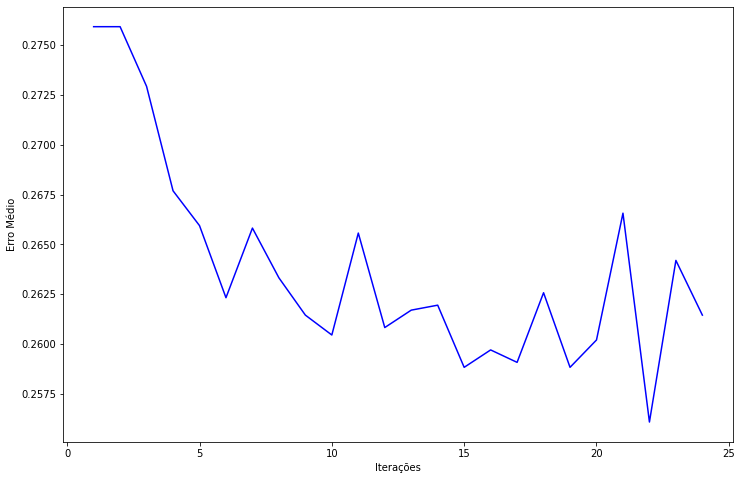

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(1,25), matriz_erro, color='blue')
plt.xlabel('Iterações')
plt.ylabel('Erro Médio')

In [ ]:
predrf

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
# Fazer a tabela final de export

table_final = pd.concat([X_test,y_test],axis=1)
table_final

,Sex,TotalDias,PrincipalColor_2,Castrado_2,Breed_2,Classifier
13814,0,60.0,51,2,640,1
5707,0,4745.0,51,2,632,1
21395,1,5475.0,2,1,450,0
9142,0,365.0,17,2,425,1
17370,0,365.0,30,2,1255,0
...,...,...,...,...,...,...
6047,0,60.0,23,2,847,1
5355,0,365.0,21,0,640,0
11654,0,1825.0,16,2,407,0
799,1,365.0,54,1,1313,0


In [ ]:
table_final

,Sex,TotalDias,PrincipalColor_2,Castrado_2,Breed_2,Classifier
13814,0,60.0,51,2,640,1
5707,0,4745.0,51,2,632,1
21395,1,5475.0,2,1,450,0
9142,0,365.0,17,2,425,1
17370,0,365.0,30,2,1255,0
...,...,...,...,...,...,...
6047,0,60.0,23,2,847,1
5355,0,365.0,21,0,640,0
11654,0,1825.0,16,2,407,0
799,1,365.0,54,1,1313,0


In [ ]:
# Descobrir o peso das variaveis do modelo
feature_names = [f'feature {i}' for i in range(X.shape[1])]

In [ ]:
X.head()

,Sex,TotalDias,PrincipalColor_2,Castrado_2,Breed_2
0,1,365.0,15,1,1221
1,0,365.0,26,2,640
2,1,730.0,7,1,1066
3,1,21.0,8,0,640
4,1,730.0,49,1,914


In [ ]:
feature_names

['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4']

In [ ]:
# Peso das variaveis
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

feature 3    0.295100
feature 4    0.289435
feature 1    0.281882
feature 2    0.126479
feature 0    0.007104
dtype: float64

# Podemos concluir que a ordem das váriaveis que mais influenciam o modelo são:
1. Castração do Animal
2. Raça do Animal
3. Total de dias no abrigo
4. Cor do Animal
5. Sexo do Animal 